# Finetune LayoutLMv3 for detecting total amount on receipts

In [1]:
from datasets import load_dataset
import json
import os
from PIL import Image, ImageDraw, ImageFont
from tqdm.notebook import tqdm
import pandas as pd

## Download CORD Dataset

In [ ]:
# Load the dataset
data = load_dataset("naver-clova-ix/cord-v2")
data

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

Here we have 3 datasets: 
- the training set (800 images)
- the validation set (100 images)
- the test set (100 images)

Each of these datasets contains has images (of the receipts) and json ("ground truth") pairs. 

Now, we will download this dataset locally using this tree structure:
- cord_v2_dataset
    - train (training set)
        - image (receipt)
        - json (ground truth)
    - validation (validation set)
        - image
        - json
    - test (test set)
        - image
        - json

In [ ]:
# Load the cord-v2 dataset
data = load_dataset("naver-clova-ix/cord-v2")

# Create dataset path
dataset_path = './cord_v2_dataset'
os.makedirs(dataset_path, exist_ok=True)

# Download dataset

# For each splits of the cord-v2 dataset (train set, validation set and test set)
for split_name, split_dataset in data.items():
    
    # Create split dataset path
    split_dataset_path = os.path.join(dataset_path, split_name)
    os.makedirs(split_dataset_path, exist_ok=True)
    
    # For each pair (image-json) in the split dataset
    for i in tqdm(range(len(split_dataset)), desc=f"Download {split_name} dataset"):
        
        # Prefix of the file name
        prefix_filename = f"receipt_{i:0{3}d}"
        
        # Download image
        image = split_dataset[i]['image'] # Image
        image_path = os.path.join(split_dataset_path, "image") # Image path
        os.makedirs(image_path, exist_ok=True) # Create image path
        image.save(f"{image_path}/{prefix_filename}.png") # Save image in image path with the right file name
        
        # Downlad json
        ground_truth = split_dataset[i]['ground_truth'] # json file in string type
        ground_truth = json.loads(ground_truth) # json file
        ground_truth_path = os.path.join(split_dataset_path, "json") # json path
        os.makedirs(ground_truth_path, exist_ok=True) # Create json path
        with open(f"{ground_truth_path}/{prefix_filename}.json", "w") as f: # Save json in json path with the right file name
            json.dump(ground_truth, f, indent=4)
        
        

Download train dataset:   0%|          | 0/800 [00:00<?, ?it/s]

Download validation dataset:   0%|          | 0/100 [00:00<?, ?it/s]

Download test dataset:   0%|          | 0/100 [00:00<?, ?it/s]

## EDA

### Images

Here is an example of a receipt in the dataset cord-v2

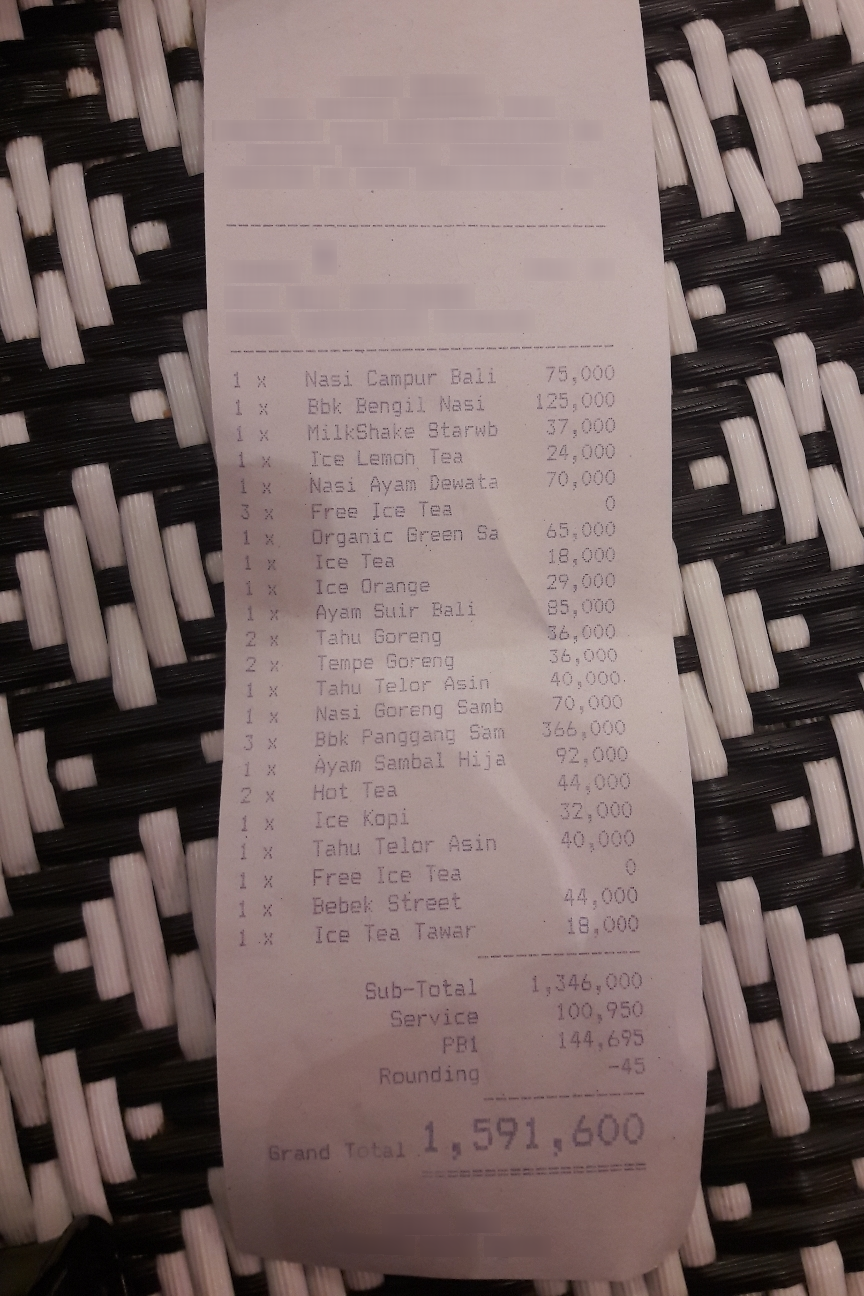

In [3]:
ex_image = Image.open('./cord_v2_dataset/train/image/receipt_000.png')
ex_image

### Json informations

Here is an example of a json file

In [4]:
with open('./cord_v2_dataset/train/json/receipt_000.json', "r") as f:
    ex_json = json.load(f)
ex_json

{'gt_parse': {'menu': [{'nm': 'Nasi Campur Bali',
    'cnt': '1 x',
    'price': '75,000'},
   {'nm': 'Bbk Bengil Nasi', 'cnt': '1 x', 'price': '125,000'},
   {'nm': 'MilkShake Starwb', 'cnt': '1 x', 'price': '37,000'},
   {'nm': 'Ice Lemon Tea', 'cnt': '1 x', 'price': '24,000'},
   {'nm': 'Nasi Ayam Dewata', 'cnt': '1 x', 'price': '70,000'},
   {'nm': 'Free Ice Tea', 'cnt': '3 x', 'price': '0'},
   {'nm': 'Organic Green Sa', 'cnt': '1 x', 'price': '65,000'},
   {'nm': 'Ice Tea', 'cnt': '1 x', 'price': '18,000'},
   {'nm': 'Ice Orange', 'cnt': '1 x', 'price': '29,000'},
   {'nm': 'Ayam Suir Bali', 'cnt': '1 x', 'price': '85,000'},
   {'nm': 'Tahu Goreng', 'cnt': '2 x', 'price': '36,000'},
   {'nm': 'Tempe Goreng', 'cnt': '2 x', 'price': '36,000'},
   {'nm': 'Tahu Telor Asin', 'cnt': '1 x', 'price': '40,000.'},
   {'nm': 'Nasi Goreng Samb', 'cnt': '1 x', 'price': '70,000'},
   {'nm': 'Bbk Panggang Sam', 'cnt': '3 x', 'price': '366,000'},
   {'nm': 'Ayam Sambal Hija', 'cnt': '1 x', 'pric

In [5]:
ex_json.keys()

dict_keys(['gt_parse', 'meta', 'valid_line', 'roi', 'repeating_symbol', 'dontcare'])

As you can see, the json hase multiple keys. The one that interests us most is valid_line. 


In [ ]:
ex_json['valid_line']

[{'words': [{'quad': {'x2': 244,
     'y3': 390,
     'x3': 244,
     'y4': 390,
     'x1': 232,
     'y1': 372,
     'x4': 232,
     'y2': 372},
    'is_key': 0,
    'row_id': 2179893,
    'text': '1'},
   {'quad': {'x2': 270,
     'y3': 390,
     'x3': 270,
     'y4': 390,
     'x1': 256,
     'y1': 374,
     'x4': 256,
     'y2': 374},
    'is_key': 0,
    'row_id': 2179893,
    'text': 'x'}],
  'category': 'menu.cnt',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x2': 354,
     'y3': 390,
     'x3': 354,
     'y4': 390,
     'x1': 302,
     'y1': 368,
     'x4': 302,
     'y2': 368},
    'is_key': 0,
    'row_id': 2179893,
    'text': 'Nasi'},
   {'quad': {'x2': 440,
     'y3': 391,
     'x3': 439,
     'y4': 388,
     'x1': 364,
     'y1': 365,
     'x4': 363,
     'y2': 368},
    'is_key': 0,
    'row_id': 2179893,
    'text': 'Campur'},
   {'quad': {'x2': 497,
     'y3': 385,
     'x3': 499,
     'y4': 388,
     'x1': 446,
     'y1': 365,
     'x4': 448,
     'y2

In [ ]:
ex_json['valid_line'][0]

{'words': [{'quad': {'x2': 244,
    'y3': 390,
    'x3': 244,
    'y4': 390,
    'x1': 232,
    'y1': 372,
    'x4': 232,
    'y2': 372},
   'is_key': 0,
   'row_id': 2179893,
   'text': '1'},
  {'quad': {'x2': 270,
    'y3': 390,
    'x3': 270,
    'y4': 390,
    'x1': 256,
    'y1': 374,
    'x4': 256,
    'y2': 374},
   'is_key': 0,
   'row_id': 2179893,
   'text': 'x'}],
 'category': 'menu.cnt',
 'group_id': 3,
 'sub_group_id': 0}

*"The valid line field has crucial information for post-OCR parsing. The quad field contains four coordinates of quadrilateral, and the text field has the incorporating text of the corresponding box. quad and text fields are used for OCR detection/localization and recognition task, respectively. [...] The category indicates parse class label"*

From "CORD: A Consolidated Receipt Dataset for Post-OCR Parsing" (https://openreview.net/pdf?id=SJl3z659UH)

### Labels in the receipts images

Here is all of the existing labels

In [16]:
json_path = "./cord_v2_dataset/train/json" # Path to the json folder in the train set
json_files = os.listdir(json_path) # List of all the json files in the train set
labels = set() # List of existing labels
# For each json file in the train set
for json_file in json_files:
    # json file content
    with open(f'{json_path}/{json_file}', "r") as f:
        _json = json.load(f)
    # for each word in the filed valid_line
    for valid_line in _json['valid_line']:
        labels.add(valid_line['category']) # Add the label to the set()

labels

{'menu.cnt',
 'menu.discountprice',
 'menu.etc',
 'menu.itemsubtotal',
 'menu.nm',
 'menu.num',
 'menu.price',
 'menu.sub.cnt',
 'menu.sub.nm',
 'menu.sub.price',
 'menu.sub.unitprice',
 'menu.unitprice',
 'menu.vatyn',
 'sub_total.discount_price',
 'sub_total.etc',
 'sub_total.othersvc_price',
 'sub_total.service_price',
 'sub_total.subtotal_price',
 'sub_total.tax_price',
 'total.cashprice',
 'total.changeprice',
 'total.creditcardprice',
 'total.emoneyprice',
 'total.menuqty_cnt',
 'total.menutype_cnt',
 'total.total_etc',
 'total.total_price',
 'void_menu.nm',
 'void_menu.price'}

Now, in an exemple, we'll try to put all the receipts elements into boxes. To do this, we'll use the word categories and box coordinates contained in the “valid_line” field.

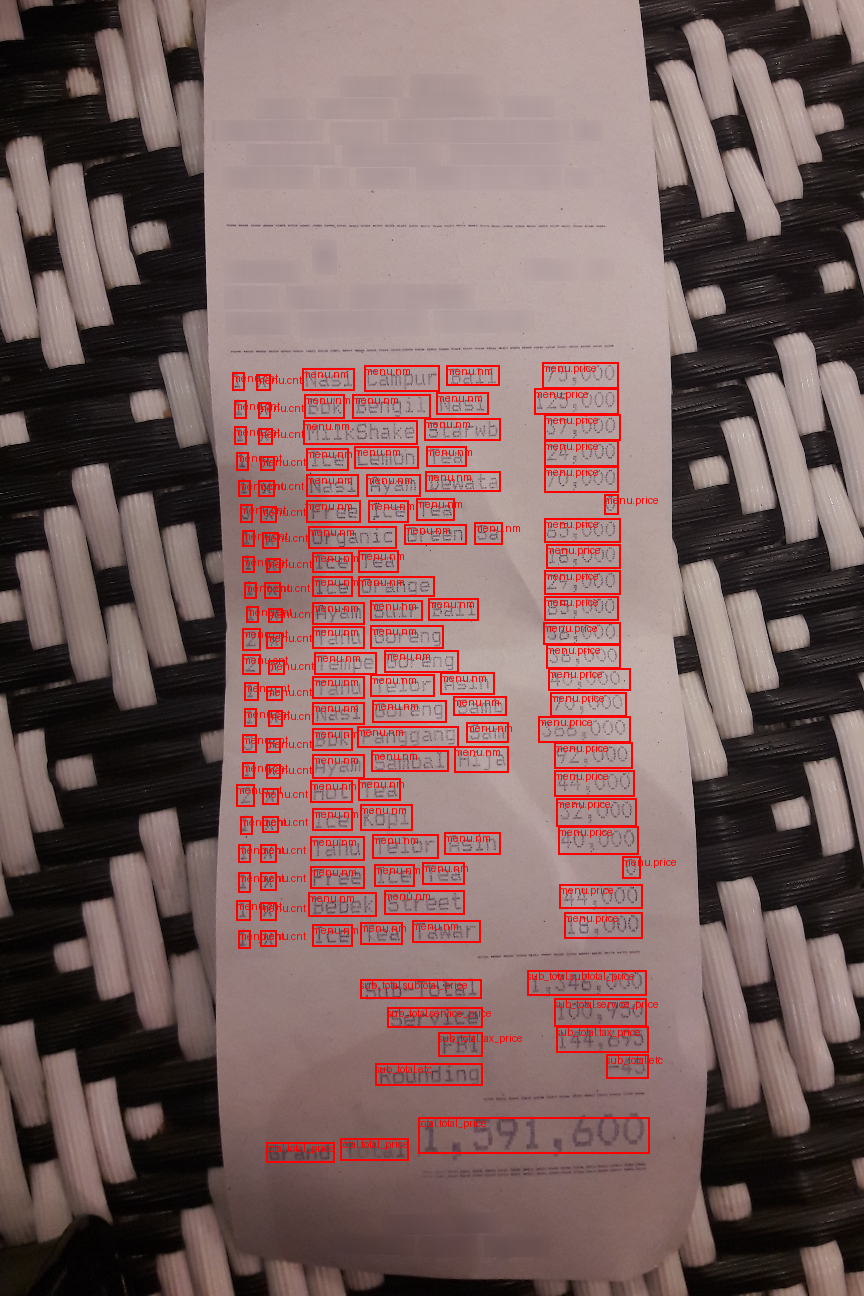

In [20]:
from PIL import ImageDraw, ImageFont, Image

# Image
ex_image = Image.open('./cord_v2_dataset/train/image/receipt_000.png')

# Json file
with open('./cord_v2_dataset/train/json/receipt_000.json', "r") as f:
    ex_json = json.load(f)

# Setup drawing
draw = ImageDraw.Draw(ex_image, "RGBA")

# Iterate over each element in the valid_line field
for valid_line in ex_json['valid_line']:
    label = valid_line['category'] # Label
    words = valid_line['words'] # List of words
    # Iterate over each word in the list words
    for word in words:
        # Coordinates of the box
        coordinates = word['quad']
        x1, y1 = coordinates['x1'], coordinates['y1']
        x3, y3 = coordinates['x3'], coordinates['y3']
        box = [x1, y1, x3, y3]
        
        # Draw
        draw.rectangle(box, outline="#FF0000", width=2)
        draw.text((box[0], box[1]), label, fill="#FF0000", font=font)
    
ex_image

## Generate new dataset

Now, we will create a new dataset containing only the words, the bounding boxes and the lables of theses words.

In [26]:
# Function to normalize a bounding box with image dimensions
def normalize_bbox(bbox, image_width, image_height):
    new_x1 = 1000 * (bbox[0] / image_width)
    new_y1 = 1000 * (bbox[1] / image_height)
    new_x3 = 1000 * (bbox[2] / image_width)
    new_y3 = 1000 * (bbox[3] / image_height)
    new_bbox = [int(new_x1), int(new_y1), int(new_x3), int(new_y3)]
    return new_bbox

In [29]:
from pathlib import Path

# Function to generate annotations from cord-v2 data
def generate_annotations(path: str):
    
    json_files = os.listdir(path)
    
    json_contents = [] # List of json files contents
    image_files = [] # List of images files
    
    for json_filename in json_files:
        # Image file name
        image_file = json_filename.replace('.json', '.png')
        image_files.append(image_file)
        # json file content
        with open(path + json_filename) as f:
            _json = json.load(f)
        json_contents.append(_json)
    
    # Lists of annotations
    words = []
    boxes = []
    labels = []
    images = []
    
    # Iterate over json files and their corresponding image filenames
    for _json, image in zip(json_contents, image_files):
        
        tmp_words = []
        tmp_boxes = []
        tmp_labels = []

        # Image dimensions
        image_width = _json['meta']['image_size']['width']
        image_height = _json['meta']['image_size']['height']
    
        for valid_line in _json['valid_line']:
            for word in valid_line['words']:
                # Word
                text = word['text']
                
                # Coordinates of the box
                coordinates = word['quad']
                x1, y1 = coordinates['x1'], coordinates['y1']
                x3, y3 = coordinates['x3'], coordinates['y3']
                
                # Normalize box
                box = [x1, y1, x3, y3]
                box = normalize_bbox(box, image_width=image_width, image_height=image_height)

                # Skip process invalid data
                # Ignore empty word
                if len(text) < 1: 
                    continue
                # Ignore boxes with out-of-range coordinates
                if min(box) < 0 or max(box) > 1000: 
                    continue
                # Ignore boxes with invalid dimensions (negative width/height)
                if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): 
                    continue
                
                # Label
                label = valid_line['category']

                tmp_words.append(text)
                tmp_boxes.append(box) 
                tmp_labels.append(label)
                
        words.append(tmp_words) 
        boxes.append(tmp_boxes)
        labels.append(tmp_labels)
        images.append(image)
  
    return words, boxes, labels, images

Now, we can apply the function above for generate new dataset over training, validation and test set

In [31]:
# Paths
train_path = './cord_v2_dataset/train/json/'
val_path = './cord_v2_dataset/validation/json/'
test_path = './cord_v2_dataset/test/json/'

words_train, boxes_train, labels_train, images_train = generate_annotations(train_path)
words_val, boxes_val, labels_val, images_val = generate_annotations(val_path)
words_test, boxes_test, labels_test, images_test = generate_annotations(test_path)

In [36]:
images_train[1]

'receipt_001.png'

In [37]:
labels_train[1]

['menu.cnt',
 'menu.nm',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.nm',
 'menu.price',
 'menu.sub.nm',
 'menu.sub.nm',
 'menu.cnt',
 'menu.nm',
 'menu.nm',
 'menu.price',
 'menu.sub.nm',
 'menu.sub.nm',
 'menu.cnt',
 'menu.nm',
 'menu.nm',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.nm',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.nm',
 'menu.price',
 'sub_total.subtotal_price',
 'sub_total.subtotal_price',
 'sub_total.tax_price',
 'sub_total.tax_price',
 'sub_total.service_price',
 'sub_total.service_price',
 'sub_total.service_price',
 'total.total_price',
 'total.total_price']

In [38]:
boxes_train[1]

[[64, 370, 85, 395],
 [136, 370, 291, 396],
 [314, 370, 530, 396],
 [597, 368, 736, 398],
 [62, 405, 83, 430],
 [136, 405, 293, 432],
 [314, 405, 391, 430],
 [576, 402, 738, 432],
 [162, 441, 268, 467],
 [291, 439, 393, 466],
 [60, 478, 81, 504],
 [136, 476, 270, 504],
 [287, 476, 440, 499],
 [581, 470, 743, 501],
 [160, 513, 321, 539],
 [340, 509, 442, 537],
 [57, 555, 81, 581],
 [136, 553, 244, 577],
 [262, 549, 395, 574],
 [416, 544, 493, 572],
 [604, 543, 748, 568],
 [57, 594, 81, 620],
 [133, 591, 315, 614],
 [317, 585, 399, 611],
 [415, 581, 543, 608],
 [608, 578, 751, 607],
 [57, 634, 78, 660],
 [129, 629, 322, 653],
 [342, 622, 547, 645],
 [609, 614, 754, 644],
 [131, 709, 353, 730],
 [591, 691, 761, 715],
 [616, 726, 762, 751],
 [131, 748, 214, 775],
 [133, 790, 222, 814],
 [239, 783, 355, 807],
 [618, 765, 766, 787],
 [127, 829, 303, 875],
 [396, 811, 750, 851]]

In [39]:
words_train[1]

['1',
 'SPGTHY',
 'BOLOGNASE',
 '58,000',
 '1',
 'PEPPER',
 'AUS',
 '165,000',
 'WELL',
 'DONE',
 '1',
 'WAGYU',
 'RIBEYE',
 '195,000',
 'MEDIUM',
 'WELL',
 '1',
 'ICED',
 'LEMON',
 'TEA',
 '22,000',
 '1',
 'FUSION',
 'TEA',
 'LYCHE',
 '28,000',
 '1',
 'NUTTELA',
 'BROWNIES',
 '35,000',
 'SUBTOTAL',
 '503,000',
 '52,815',
 'PB1',
 'SVC',
 'CHRG',
 '25,150',
 'DUE',
 '580,965']

Now, we can save the the new generated data

In [40]:
import pickle

os.makedirs('new_data', exist_ok=True)

# Save new dataset
with open('./new_data/new_data_train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train, images_train], t)
with open('./new_data/new_data_val.pkl', 'wb') as t:
    pickle.dump([words_val, labels_val, boxes_val, images_val], t)
with open('./new_data/new_data_test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test, images_test], t)


## Prepare data

In [1]:
import pandas as pd

train_data = pd.read_pickle('./new_data/new_data_train.pkl')
val_data = pd.read_pickle('./new_data/new_data_val.pkl')
test_data = pd.read_pickle('./new_data/new_data_test.pkl')

In [2]:
from collections import Counter

# Lists of all labels in all the files
all_labels = [item for sublist in train_data[1] for item in sublist] + [item for sublist in val_data[1] for item in sublist] + [item for sublist in test_data[1] for item in sublist]

counter = Counter(all_labels)
counter

Counter({'menu.nm': 6594,
         'menu.price': 2589,
         'menu.cnt': 2423,
         'total.total_price': 2115,
         'sub_total.subtotal_price': 1480,
         'total.cashprice': 1393,
         'total.changeprice': 1297,
         'sub_total.tax_price': 1283,
         'menu.sub.nm': 831,
         'menu.unitprice': 750,
         'total.menuqty_cnt': 630,
         'total.creditcardprice': 410,
         'menu.discountprice': 403,
         'sub_total.service_price': 353,
         'sub_total.etc': 283,
         'menu.sub.cnt': 195,
         'sub_total.discount_price': 191,
         'menu.sub.price': 163,
         'total.emoneyprice': 131,
         'total.menutype_cnt': 130,
         'menu.num': 109,
         'total.total_etc': 87,
         'menu.etc': 19,
         'menu.sub.unitprice': 14,
         'menu.vatyn': 9,
         'menu.itemsubtotal': 7,
         'sub_total.othersvc_price': 6,
         'void_menu.nm': 3,
         'void_menu.price': 1})

As we can see, there are some labels that contain very few examples. We can replace them by a neutral label "O"

### Replace all labels other than "total.total_price"

In [3]:
# !!! Function to replace all other labels by "Others" !!!
def replace_all_other_label(dataset_labels:list, label_to_keep:str):
    new_dataset_labels = []
    for i, labels in enumerate(dataset_labels):
        tmp_labels = []
        for j, label in enumerate(labels):
            if label == label_to_keep:
                tmp_labels.append(label)
            else:
                tmp_labels.append("Others")
        new_dataset_labels.append(tmp_labels)
    return new_dataset_labels

In [4]:
# Replace labels in all the sets

label_to_keep = "total.total_price"

train_data[1] = replace_all_other_label(train_data[1], label_to_keep)
val_data[1] = replace_all_other_label(val_data[1], label_to_keep)
test_data[1] = replace_all_other_label(test_data[1], label_to_keep)

In [5]:
# Counter of all the labels
all_labels = [item for sublist in train_data[1] for item in sublist] + [item for sublist in val_data[1] for item in sublist] + [item for sublist in test_data[1] for item in sublist]
Counter(all_labels)

Counter({'Others': 21784, 'total.total_price': 2115})

### Labels mapping

In [7]:
import pickle
import os

# List of unique labels
labels = list(set(all_labels))
print("Labels:", labels)

# Label encoding
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}
print("label2id:", label2id)
print("id2label", id2label)

mapping_path = "./mapping"
os.makedirs(mapping_path, exist_ok=True)

# Save dictionaries
with open(f"{mapping_path}/label2id.pkl", "wb") as f:
    pickle.dump(label2id, f)

with open(f"{mapping_path}/id2label.pkl", "wb") as f:
    pickle.dump(id2label, f)

Labels: ['total.total_price', 'Others']
label2id: {'total.total_price': 0, 'Others': 1}
id2label {0: 'total.total_price', 1: 'Others'}


### Generate encoded dataset

In [8]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image

class CORDDataset(Dataset):
    """CORD dataset"""

    def __init__(self, annotations, image_dir, processor=None):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv3Processor): Processor to prepare the text + image.
        """
        
        self.words, self.labels, self.boxes, self.image_file_names = annotations # Unpack the annotations into individual lists
        self.image_dir = image_dir # Directory where the images are stored
        self.processor = processor # The processor used to process both text and image inputs

    # Returns the total number of samples in the dataset
    def __len__(self):
        
        return len(self.image_file_names)

    # Retrieve the index of the image and its corresponding annotations (text and bounding boxes)
    def __getitem__(self, idx):
        
        # Image file name
        item = self.image_file_names[idx]
        
        #Convert image to RGB
        image = Image.open(self.image_dir + item).convert("RGB")

        # Get corresponding words, boxes, and labels for the image
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        # Check that the number of words, boxes, and labels match
        assert len(words) == len(boxes) == len(word_labels)
        
        # Convert string labels to integers using the label encoding mapping
        word_labels = [label2id[label] for label in word_labels]

        # Encode the image, words, bounding boxes, and labels using the processor
        encoded_inputs = self.processor(image, 
                                        words, 
                                        boxes=boxes, 
                                        word_labels=word_labels, 
                                        padding="max_length", # Pad sequences
                                        truncation=True, # Truncate sequences if they exceed max length
                                        return_tensors="pt" # Return as PyTorch tensors
                                        )
        
        # Squeeze tensors
        for k, v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze()
      
        return encoded_inputs

In [23]:
from transformers import LayoutLMv3Processor, LayoutLMv3TokenizerFast, LayoutLMv3FeatureExtractor, LayoutLMv3ForTokenClassification

# Load pre-trained tokenizer for LayoutLMv3 (used for processing text inputs)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained('microsoft/layoutlmv3-base')

# Load processor with tokenizer to prepare input data
processor = LayoutLMv3Processor(LayoutLMv3FeatureExtractor(apply_ocr=False), tokenizer)
# Sauvegarder le processor
processor.save_pretrained('processor')

# Encoded training dataset
train_dataset = CORDDataset(annotations=train_data, # Word-level annotations (words, labels, boxes)
                            image_dir='./cord_v2_dataset/train/image/', # Directory of the images
                            processor=processor # Processor
                            )

# Encoded Validation dataset
val_dataset = CORDDataset(annotations=val_data,
                          image_dir='./cord_v2_dataset/validation/image/', 
                          processor=processor
                          )

# Encoded Test dataset
test_dataset = CORDDataset(annotations=test_data,
                           image_dir='./cord_v2_dataset/test/image/', 
                           processor=processor
                           )

c:\Users\hugol\anaconda3\envs\test_dataleon\lib\site-packages\transformers\models\layoutlmv3\feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


In [10]:
encoding = train_dataset[0]

for k,v in encoding.items():
    print(k, v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
pixel_values torch.Size([3, 224, 224])


Now we have the encoded datasets, we can load them in batches

In [11]:
from torch.utils.data import DataLoader

# Load the data in batches
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

## Train model

In [12]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU is available.


In [13]:
torch.__version__

'2.5.1+cu124'

In [14]:
from transformers import LayoutLMv3ForTokenClassification, AdamW
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import DataLoader

# Function to train the model for token classification
def train_model(data, labels:list, batch_size:int, epochs:int, path:str):
    
    torch.cuda.empty_cache()
    
    # Load the data in batches
    train_dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    
    # Load LayoutLMv3 model
    model = LayoutLMv3ForTokenClassification.from_pretrained('microsoft/layoutlmv3-base', num_labels=len(labels))
    
    # Move model to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Initialize the AdamW optimizer
    optimizer = AdamW(model.parameters(), lr=5e-5)
    
    # Training parameters
    global_step = 0
    epochs = 3
    
    # TRAIN MODEL
    model.train()
    for epoch in range(epochs): # Iterate over epochs

        for batch in tqdm(train_dataloader):  # Iterate over batches of the training dataset
            
            # Get inputs
            input_ids = batch['input_ids'].to(device)  # Token IDs
            bbox = batch['bbox'].to(device)  # Bounding boxes
            pixel_values = batch['pixel_values'].to(device)  # Image data as pixel values
            attention_mask = batch['attention_mask'].to(device)  # Attention mask for padding
            labels = batch['labels'].to(device)  # Labels

            # Reset gradients before each optimization step.
            optimizer.zero_grad()
            
            # Forward pass:
            outputs = model(input_ids=input_ids,
                            bbox=bbox,
                            pixel_values=pixel_values,
                            attention_mask=attention_mask,
                            labels=labels
                            )
            loss = outputs.loss  # Loss from model
            
            # Print the loss every 100 steps for monitoring.
            if global_step % 100 == 0:
                print(f"Loss after {global_step} steps: {loss.item()}")

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Increment global step counter
            global_step += 1

    # Save the trained model
    model.save_pretrained(path)
    
    return model


In [15]:
model = train_model(train_dataset, labels=labels, batch_size=2, epochs=4, path="./model")

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hugol\anaconda3\envs\test_dataleon\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/400 [00:00<?, ?it/s]

c:\Users\hugol\anaconda3\envs\test_dataleon\lib\site-packages\transformers\modeling_utils.py:1161: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loss after 0 steps: 0.6795058846473694
Loss after 100 steps: 0.39195922017097473
Loss after 200 steps: 0.06455227732658386
Loss after 300 steps: 0.01206812635064125


  0%|          | 0/400 [00:00<?, ?it/s]

Loss after 400 steps: 0.0055235945619642735
Loss after 500 steps: 0.000798512832261622
Loss after 600 steps: 0.0068098702467978
Loss after 700 steps: 0.0050918408669531345


  0%|          | 0/400 [00:00<?, ?it/s]

Loss after 800 steps: 0.003092193976044655
Loss after 900 steps: 0.00284864311106503
Loss after 1000 steps: 0.002049850532785058
Loss after 1100 steps: 0.0022099323105067015


### Try model

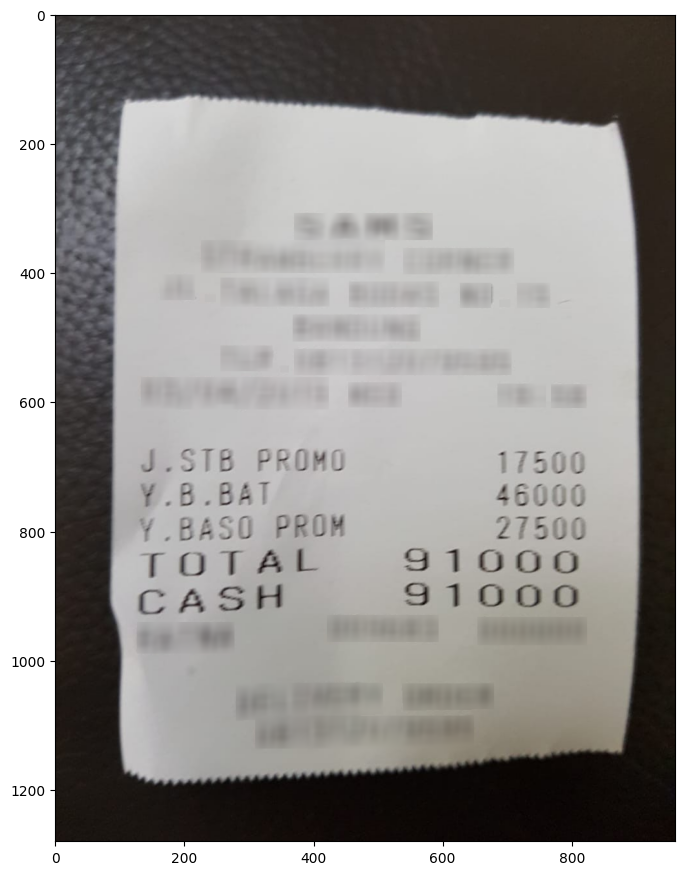

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

# Load image from local storage
img = Image.open("./cord_v2_dataset/test/image/"+ test_data[3][1])
plt.figure(figsize = (8, 12))
plt.imshow(img, cmap='gray')

Let's try to get the labels of the tokens in this receipt

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

# Load trained model
model_path = "./model"
model = LayoutLMv3ForTokenClassification.from_pretrained(model_path)

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Encoded input data for testing
encoding = test_dataset[1]
processor.tokenizer.decode(encoding['input_ids'])

# Prepare the data for model inference
for k,v in encoding.items():
    encoding[k] = v.unsqueeze(0).to(device)

# MODEL EVAL
model.eval()

# Forward pass
outputs = model(input_ids=encoding['input_ids'],
                attention_mask=encoding['attention_mask'],
                bbox=encoding['bbox'],
                pixel_values=encoding['pixel_values']
                )

# Extract the predicted class indices for each token
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()

# Load mapping dictionary
with open("./mapping/id2label.pkl", "rb") as f:
    id2label = pickle.load(f)

# Convert predictions indices into labels
predictions = [id2label[label] for gt, label in zip(encoding['labels'].squeeze().tolist(), prediction_indices) if gt != -100]
predictions
     

c:\Users\hugol\anaconda3\envs\test_dataleon\lib\site-packages\transformers\modeling_utils.py:1161: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


['Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'total.total_price',
 'total.total_price',
 'Others',
 'Others']

Now we have the labels, we can get text values of tokens with label 'total.total_price'

In [18]:
# Decode the input tokens into a list of readable strings
decoded_tokens = processor.tokenizer.decode(encoding['input_ids'].squeeze().tolist(), skip_special_tokens=True).split()

# Initialize an empty list to collect tokens for total.total_price
total_price_tokens = []

# Iterate over each token and its predicted label
for token, prediction in zip(decoded_tokens, predictions):
    if prediction == "Others":
        continue
    else:
        total_price_tokens.append(token)
        
# Tokens corresponding to "total.total_price"
total_price_tokens

['TOTAL', '91000']

## Evaluation on the test set

In [19]:
import numpy as np

# Set the model in evaluation mode
# model.eval()

# Function to get predictions
def evaluate(dataloader, model_path:str):
    
    # Initialize variables to store predictions and labels
    preds_val = None
    out_label_ids = None
    
    # Load trained model
    model = LayoutLMv3ForTokenClassification.from_pretrained(model_path)
    
    # Move model to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Set the model in evaluation mode (this is important for disabling dropout and other training-specific operations)
    model.eval()
    
    # Iterate over batches in the dataloader
    for batch in tqdm(dataloader, desc="Evaluating"):
        with torch.no_grad():
            
            # Get input data and labels
            input_ids = batch['input_ids'].to(device)
            bbox = batch['bbox'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, 
                            bbox=bbox, 
                            attention_mask=attention_mask, 
                            pixel_values=pixel_values, 
                            labels=labels
                            )
            
            # If first batch, initialize prediction and label arrays
            if preds_val is None:
                preds_val = outputs.logits.detach().cpu().numpy()
                out_label_ids = batch["labels"].detach().cpu().numpy()
            else:
                preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(
                    out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
                )
                
    # Return predictions and labels
    return preds_val, out_label_ids

In [20]:
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

# Function to compute evaluation metrics: precision, recall, f1
def results_test(preds, out_label_ids, labels):
    
    # Index of the highest value
    preds = np.argmax(preds, axis=2)
    
    # Mapping
    label_map = {i: label for i, label in enumerate(labels)}

    # Initialize empty lists to store the true labels and predicted labels for each example
    out_label_list = [[] for _ in range(out_label_ids.shape[0])]
    preds_list = [[] for _ in range(out_label_ids.shape[0])]

    for i in range(out_label_ids.shape[0]):
        for j in range(out_label_ids.shape[1]):
            if out_label_ids[i, j] != -100:
                out_label_list[i].append(label_map[out_label_ids[i][j]])
                preds_list[i].append(label_map[preds[i][j]])

    results = {
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }
    
    return results, classification_report(out_label_list, preds_list)

In [21]:
# Load trained model
model_path = "./model"
preds_val, out_label_ids = evaluate(test_dataloader, model_path)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\hugol\anaconda3\envs\test_dataleon\lib\site-packages\transformers\modeling_utils.py:1161: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [22]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.9270833333333334, 'recall': 0.9368421052631579, 'f1': 0.9319371727748692}
                  precision    recall  f1-score   support

otal.total_price       0.93      0.94      0.93        95

       micro avg       0.93      0.94      0.93        95
       macro avg       0.93      0.94      0.93        95
    weighted avg       0.93      0.94      0.93        95



c:\Users\hugol\anaconda3\envs\test_dataleon\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\hugol\anaconda3\envs\test_dataleon\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: total.total_price seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


- Of all the instances where the model predicted total.total_price, it was correct 93% of the time.
- The model detected 94% of the actual total.total_price instances. It missed only 6% of them.
- F1-Score for total.total_price: 0.93

The model trained on 2 labels appears to be successfully identifying the total.total_price label, with a good balance between identifying all occurrences (recall) and minimizing false positives (good precision).